<a href="https://colab.research.google.com/github/iampatgrady/Simple-Probabalistic-Model-For-Google-Analytics-Users/blob/master/Multitouch_Attribution_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probabilistic Multi-Touch Attribution Model

<img src="https://storage.googleapis.com/pats-test/images/multi-touch.png">

We will demonstrate how to apply a probabilistic, multi-touch attribution model to your GA data using Python and BigQuery libraries. The procedure in this notebook is based on an article published in 2011 by [Xuhui Shao.](https://www.linkedin.com/in/xuhuishao/) The resulting score helps marketers better understand their channel investments.

Big thanks to [Anže Kravanja](https://www.linkedin.com/in/an%C5%BEe-kravanja-54006194/), [Luka Cempre](https://www.linkedin.com/in/luka-cempre-9b5ba71a/), and [Clay Porter](https://www.linkedin.com/in/clayporter1/) for their help in putting this notebook together!

Here is the author, [Xuhui Shao](https://www.linkedin.com/in/xuhuishao/), describing the <a href="https://www.clickz.com/the-math-behind-multi-touch-attribution/50028/">math behind the model</a>:  

<img src="https://storage.googleapis.com/pats-test/images/model.png">  
>Let’s say for one converted user, email contributes 15 percent alone and makes other channels such as display and video 20 percent better. The overall contribution of email to this conversion is 35 percent.

>The contributions of all the touch points are then normalized to ensure they always add up to 100 percent. In other words, the credit of the conversion is proportionately assigned to each touch point based on its relative contribution in increasing the user’s probability to convert.

In [0]:
import pandas as pd
import numpy as np
import itertools
import urllib2
import matplotlib.pylab as plt
plt.style.use("fivethirtyeight")

## Query GA Data in BigQuery
The <a href="https://storage.googleapis.com/pats-test/sql/multi_touch_attribution.sql">multi_touch_attribution.sql</a> SQL is used to format our data in the appropriate schema for our data pipeline.

You'll want to download and inspect the SQL, and then upload that file to your local Drive directory below:

You're ready to execute the query after adding a target table and start and end dates. In our case we're using the BigQuery GA data for Google Merchandize Store.


In [0]:
#@title Enter your BigQuery project ID { run: "auto", display-mode: "form" }
project = "as-dev-pat" #@param {type:"string"}
target = "bigquery-public-data.google_analytics_sample.ga_sessions_*" #@param {type:"string"}
start = "2016-07-01" #@param {type:"date"}
end = "2017-08-01" #@param {type:"date"}


In [20]:
from google.colab import auth
auth.authenticate_user()

sql_query = urllib2 \
  .urlopen("https://storage.googleapis.com/pats-test/sql/multi_touch_attribution.sql") \
  .read().format(target,start.replace("-",""),end.replace("-",""))

ga_data = pd.io.gbq.read_gbq(sql_query,project_id=project,dialect='standard')

print ga_data.shape
ga_data.sample(5)

(714167, 3)


,fullVisitorId,channels,converted
134192,1884374490201862036,[Organic Search],0
610134,8542907014444995770,[Referral],0
670343,9387190185114213,[Affiliates],0
323015,4530222971404581209,[Organic Search],0
490661,6874898469775205917,[Organic Search],0


## Individual Channel Probability

<img src="https://storage.googleapis.com/pats-test/images/channel_probability.jpg">  

    P(y|xi) = positives / positives + negatives = conversions / users = channel conversion rate  


In [21]:
channel_metrics_map = {}  

for user in ga_data.to_records(): 
    
    for channel in user["channels"]:
        
        if not channel in channel_metrics_map:
            channel_metrics_map[channel] = { "conversions": 0.0, "users": 0.0 }
            
        channel_metrics_map[channel]["conversions"] += float(user["converted"])
        channel_metrics_map[channel]["users"] += 1.0 

pd.DataFrame(channel_metrics_map).transpose().sort_values(by='conversions',ascending=False)

,conversions,users
Referral,4685.0,65507.0
Organic Search,3496.0,311429.0
Direct,2223.0,109795.0
Paid Search,554.0,18600.0
Display,201.0,4027.0
Social,118.0,212352.0
Affiliates,14.0,13399.0
(Other),1.0,86.0


## Pairwise Channel Probabilities

<img src="https://storage.googleapis.com/pats-test/images/pairwise_probability.png">

In [22]:
channel_metrics = channel_metrics_map.copy()

for xi,xj in itertools.combinations(channel_metrics.keys(), 2):
    
    key = "{}|{}".format(xi, xj)
    
    for user in ga_data.loc[ga_data.channels.map(lambda c: ((xi in c) & (xj in c))) == True].to_records():
         
        if not key in channel_metrics: 
            channel_metrics[key] = { "conversions": 0.0, "users": 0.0 }

        channel_metrics[key]["conversions"] += float(user[3]) 
        channel_metrics[key]["users"] += 1.0 

pd.DataFrame(channel_metrics).transpose().sort_values(by='conversions', ascending=False) \
    .reset_index().rename(columns={'index':'channels'})[:10]

,channels,conversions,users
0,Referral,4685.0,65507.0
1,Organic Search,3496.0,311429.0
2,Direct,2223.0,109795.0
3,Paid Search,554.0,18600.0
4,Direct|Referral,393.0,3141.0
5,Referral|Organic Search,380.0,4738.0
6,Display,201.0,4027.0
7,Paid Search|Organic Search,169.0,3688.0
8,Direct|Organic Search,129.0,2988.0
9,Social,118.0,212352.0


### Add calculated field: `Conversion Rate`

In [23]:
for key in channel_metrics:
    channel_metrics[key]["conversion rate"] = np.divide(
        channel_metrics[key]["conversions"] , 
        channel_metrics[key]["users"]
    )

pd.DataFrame(channel_metrics).transpose().sort_values(by='conversions', ascending=False) \
    .reset_index().rename(columns={'index':'channels'})[:5]

,channels,conversion rate,conversions,users
0,Referral,0.071519,4685.0,65507.0
1,Organic Search,0.011226,3496.0,311429.0
2,Direct,0.020247,2223.0,109795.0
3,Paid Search,0.029785,554.0,18600.0
4,Direct|Referral,0.125119,393.0,3141.0


## Simple Multi-Touch Probabilistic Model
<img src="https://storage.googleapis.com/pats-test/images/model.png">

In [24]:
channels = [ c for c in channel_metrics.keys() if not "|" in c ]
channel_contrib = {} 

for channel in channels:
    
    p_xi = channel_metrics[channel]["conversion rate"]
    
    combinations = [ c for c in channel_metrics.keys() if channel in c and "|" in c ] 
    n = np.divide(1.0 , float(2 * len(combinations)))
    
    sum_part = []
    
    for combination in combinations:
        
        xi_xj = channel_metrics[combination]["conversion rate"]
                                             
        xi = channel_metrics[ combination.split("|")[0] ]["conversion rate"]
        xj = channel_metrics[ combination.split("|")[1] ]["conversion rate"]
                                             
        sum_part.append(xi_xj - xi - xj)
    
    s = np.sum(sum_part)
    channel_contrib[channel] = p_xi + n * (s if s > 0 else 0)

pd.DataFrame([channel_contrib]).transpose()

,0
(Other),0.011628
Affiliates,0.001045
Direct,0.020247
Display,0.049913
Organic Search,0.011226
Paid Search,0.029785
Referral,0.071519
Social,0.000556


### Covert to `% of Total`, column sums to 1

In [25]:
c_sum = np.sum([ channel_contrib[ch] for ch in channel_contrib.keys() ])
for key in channel_contrib.keys():
    channel_contrib[key] /= c_sum
    
results = pd.DataFrame(channel_contrib.items())
results.columns=['channel','contribution']
print "The contribution column sums to {}".format(sum(results["contribution"]))
results.sort_values(by='contribution',ascending=False).reset_index(drop=True)

The contribution column sums to 1.0


,channel,contribution
0,Referral,0.365046
1,Display,0.254765
2,Paid Search,0.152028
3,Direct,0.103343
4,(Other),0.059351
5,Organic Search,0.057298
6,Affiliates,0.005333
7,Social,0.002836


### Add context by creating weighted fields

In [26]:
results["conversions"] = results.channel.map(lambda x: channel_metrics[x]["conversions"])

results["score"] = results["conversions"] * results["contribution"]

results['importance'] = np.divide(
    results['score']-results['score'].min() , 
    results['score'].max()-results['score'].min()
)

results = results.sort_values('importance',ascending=False).fillna(0).reset_index(drop=True)
results

,channel,contribution,conversions,score,importance
0,Referral,0.365046,4685.0,1710.239922,1.000000
1,Direct,0.103343,2223.0,229.732227,0.134297
2,Organic Search,0.057298,3496.0,200.313102,0.117095
3,Paid Search,0.152028,554.0,84.223279,0.049213
4,Display,0.254765,201.0,51.207791,0.029908
5,Social,0.002836,118.0,0.334683,0.000161
6,Affiliates,0.005333,14.0,0.074664,0.000009
7,(Other),0.059351,1.0,0.059351,0.000000


## Visualize the data  

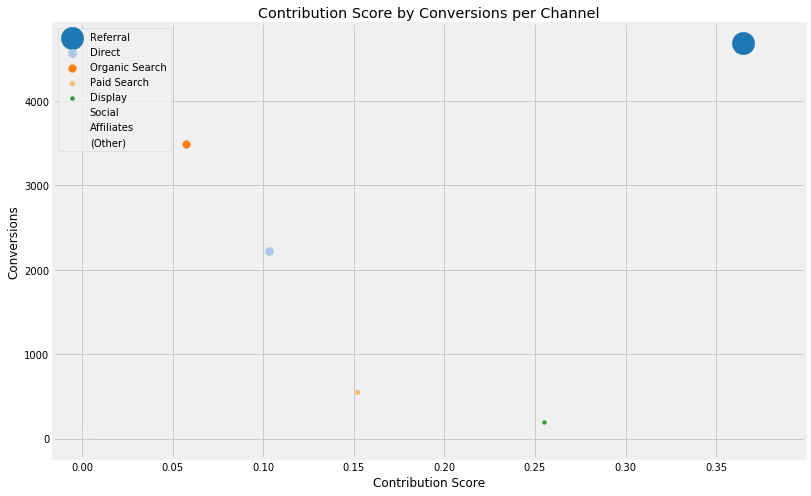

In [27]:
fig, ax = plt.subplots(figsize=(12,8))
cmap = plt.cm.get_cmap('tab20')
for i,row in results.iterrows():
  ax.scatter("contribution", "conversions",label=row.channel,
             s=row.importance*500, c=cmap(i), data=row)
plt.xlabel("Contribution Score")
plt.ylabel("Conversions")
plt.title("Contribution Score by Conversions per Channel")
plt.legend(loc=0)
plt.show()

<h3>Contribution Score over 12 weeks (example):</h3>

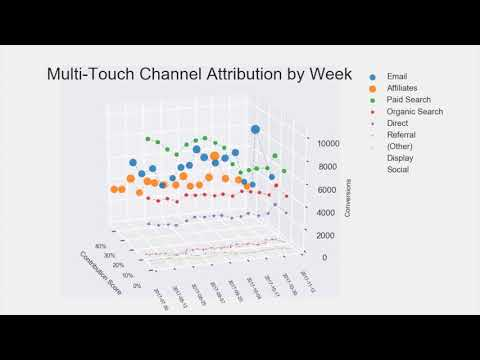

In [28]:
from IPython.display import YouTubeVideo
YouTubeVideo("OBZILfAf4xQ",width=768, height=432)